# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

In [5]:
!pip install transformers torch  

# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT

You should consider upgrading via the 'C:\Users\vcs\Desktop\UNI\MSc_CS\Y2\Q1\RS\rec_sys\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    BERT_AVAILABLE = True
    print("BERT libraries loaded successfully!")
    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    print(f"Using device: {device}")
except ImportError:
    BERT_AVAILABLE = False
    print("BERT libraries not available. Install with: pip install transformers torch")

Check the status of BERT installation:
BERT libraries loaded successfully!
Using device: cuda


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import re
import time, math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


# Load dataset

In [36]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('test.txt', sep='\t', names=columns_name)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')

The training data:


,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


The shape of the training data: (80000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


In [9]:
movies = pd.read_csv('movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

### A. Content Based Recommender

#### A.1 Deriving Content Representation with BERT

In [10]:
def create_bert_embeddings(content):
    """
    Generate BERT embeddings for movie content.

    Args:
        content: Content of items

    Returns:
        numpy.ndarray: BERT embeddings matrix
    """
    if not BERT_AVAILABLE:
        print("BERT libraries not available. Install with: pip install transformers torch")
        return None

    if content is None:
        return None

    if isinstance(content, pd.Series):
        content = content.fillna("").astype(str).tolist()
    elif isinstance(content, np.ndarray):
        content = content.astype(str).tolist()

    model_name = 'distilbert-base-uncased'

    print(f"Loading BERT model: {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Set device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using cuda or cpu: {device}")
    model.to(device)
    model.eval()

    print(f"Using device: {device}")

    # Generate embeddings in batches
    batch_size = 32  # Adjust based on available memory
    emb = []

    for i in range(0, len(content), batch_size):
        if i % (batch_size * 10) == 0:
            print(f"Processing batch {i//batch_size + 1}/{len(content)//batch_size + 1}")

        batch_texts = content[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            emb.extend(batch_embeddings)

    emb = np.array(emb)

    print(f"BERT embeddings generated: {emb.shape}")
    print(f"Embedding dimension: {emb.shape[1]}")

    return emb

#### A.2 Deriving the representation of items for three types of content: 
- title + genres 
- description 
- title + genres + description

In [11]:
# Implement code to derive the content representation for title and genres. Concatenate the two content as: title + ' ' + genres
item_emb_titlegenres = None
############# Your code here ############
title_genres_text = (movies['title'].astype(str) + ' ' + movies['genres'].astype(str)).tolist()
item_emb_titlegenres = create_bert_embeddings(title_genres_text)
#########################################

# Implement code to derive the content representation for description.
item_emb_description = None
############# Your code here ############
description_text = movies['description'].fillna("").astype(str).tolist()
item_emb_description = create_bert_embeddings(description_text)
#########################################

# Implement code to derive the content representation for title, genres, and description. Concatenate the two content as: title + ' ' + genres + '' + description
item_emb_full = None
############# Your code here ############
full_text = (movies['title'].astype(str) + ' ' + 
             movies['genres'].astype(str) + ' ' + 
             movies['description'].fillna("").astype(str)).tolist()
item_emb_full = create_bert_embeddings(full_text)
#########################################

Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/53
Processing batch 11/53
Processing batch 21/53
Processing batch 31/53
Processing batch 41/53
Processing batch 51/53
BERT embeddings generated: (1682, 768)
Embedding dimension: 768
Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/53
Processing batch 11/53
Processing batch 21/53
Processing batch 31/53
Processing batch 41/53
Processing batch 51/53
BERT embeddings generated: (1682, 768)
Embedding dimension: 768
Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/53
Processing batch 11/53
Processing batch 21/53
Processing batch 31/53
Processing batch 41/53
Processing batch 51/53
BERT embeddings generated: (1682, 768)
Embedding dimension: 768


#### A.3 Get Item Embeddings

In [12]:
def get_item_emb(item_id, content_type):
    # Implement the function that given content type (title+genres, description, or title+genres+description) returns the embedding derived for the corresponding item_id. 
    # Hint1: keep in mind that item_id in the data starts from 1, but in the embedding variable it starts from 0, e.g., item_id 100 corresponds to index 99 in embedding variable..
    # Hint2: use if-else conditions to return the embedding for the requested content types.
    # Hint3: use the global variables (embeddings) already computed in previous cells.

    emb = None
    
    ############# Your code here ############
    idx = int(item_id) - 1
    if content_type == 'title_genres':
        emb = item_emb_titlegenres[idx]
    elif content_type == 'description':
        emb = item_emb_description[idx]
    else:
        emb = item_emb_full[idx]
    #########################################

    return emb

#### A.4 User Profile Construction

In [13]:
def get_interacted_items_embs_rating(train_data, user_id, content_type):
    # Implement the function that given content type (title+genres, description, or title+genres+description) returns the embeddings and ratings of interacted items by user_id=100. 
    # Hint1: use train_data to retrieve the item_ids that target user (user_id=100 in this example) interacted, then pass these item_ids to function previously implemented to retrieve the embeddings and ratings.

    embs, ratings = [], []
    
    ############# Your code here ############
    user_interactions = train_data[train_data['user_id'] == user_id]

    for _, row in user_interactions.iterrows():
        item_id = row['item_id']
        rating = row['rating']
        
        # Get embedding for this item
        emb = get_item_emb(item_id, content_type)
        
        if emb is not None:
            embs.append(emb)
            ratings.append(rating)
    #########################################

    return embs, ratings

#### A.5 Deriving the representation for a user using the following aggregation methods:
1. **avg:** Average representation of interacted item 
2. **weighted_avg:** Weighted average representation of interacted item using rating values
3. **avg_pos:** Average representation of positively interacted item (ratings >= 4)

In [14]:
def get_user_emb(train_data, user_id, content_type, aggregation_method):
    # Implement the function that given content type (title+genres, description, or title+genres+description) and aggregation method (avg, weighted_avg, avg_pos) returns the representation of a user. 
    # Hint1: use the previsouly implemented items for retrieving ratings and representation of interacted items by a user.

    emb = []
    
    ############# Your code here ############
    embs, ratings = get_interacted_items_embs_rating(train_data, user_id, content_type)

    embs = np.array(embs)
    ratings = np.array(ratings)

    if aggregation_method == 'avg':
        emb = np.mean(embs, axis=0)

    elif aggregation_method == 'weighted_avg':
        weights = ratings / ratings.sum()
        emb = np.average(embs, axis=0, weights=weights)

    else: 
        mask = ratings >= 4
        if mask.sum() == 0:
            return None  
        emb = np.mean(embs[mask], axis=0)
    #########################################

    return emb

#### A.6 Predict Score for User-Item Pair

In [15]:
def get_user_item_prediction(train_data, user_id, item_id, content_type, aggregation_method):
    # Implement the function that given content type and aggregation method returns the predicted rating for a user-item pair. 
    # Hint1: use the previsouly implemented functions for retrieving the embeddings and then compute the dot product of user and item embeddings.

    pred_rating = 0.0
    
    ############# Your code here ############
    user_emb = get_user_emb(train_data, user_id, content_type, aggregation_method)
    item_emb = get_item_emb(item_id, content_type)    
    pred_rating = float(np.dot(user_emb, item_emb))
    #########################################

    return pred_rating
    
user_id, item_id = 100, 266
content_type, aggregation_method = 'full', 'avg' # alternatives are content_type={title_genres,description,full} and aggregation_method={avg,weighted_avg,avg_pos}
print('Predicted score for user_id=100 and item_id=266 for content type '+content_type+' and aggregation method '+aggregation_method+':')
print(get_user_item_prediction(train_data, user_id, item_id, content_type, aggregation_method))

Predicted score for user_id=100 and item_id=266 for content type full and aggregation method avg:
142.68702697753906


### B. User-based neighborhood method

#### B.1 Implementing a function that computes the Pearson Correlation between two users. 

The **Pearson correlation coefficient** between two users \(x\) and \(y\) is defined as:

$$
r_{xy} = \frac{\sum_{i \in I_{xy}} (x_i - \bar{x})(y_i - \bar{y})}
              {\sqrt{\sum_{i \in I_{xy}} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i \in I_{xy}} (y_i - \bar{y})^2}}
$$

**Where:**

- $I_{xy}$ = set of items rated by both users  
- $x_i$, $y_i$ = ratings of users \(x\) and \(y\) on item \(i\)  
- $\bar{x}$, $\bar{y}$ = mean ratings of users \(x\) and \(y\) on the common items  


In [16]:
def pearson_correlation(user1_ratings: pd.Series, user2_ratings: pd.Series) -> float:
    """
    Compute Pearson correlation coefficient between two users' rating vectors.
    
    user1_ratings, user2_ratings: Pandas Series indexed by item IDs. They may contain NaN for unrated items.
    Returns: float (correlation between -1 and 1). Returns 0 if not enough data.
    """
    # Find the common items both users have rated
    common_items = user1_ratings.index.intersection(user2_ratings.index)
    
    if len(common_items) < 2:
        # Not enough common ratings to compute correlation
        return 0.0

    # Extract the ratings for the common items
    u1 = user1_ratings.loc[common_items]
    u2 = user2_ratings.loc[common_items]

    # Drop any NaNs just in case
    valid = u1.notna() & u2.notna()
    u1 = u1[valid]
    u2 = u2[valid]

    if len(u1) < 2:
        return 0.0

    # Compute mean-centered ratings
    u1_mean = u1.mean()
    u2_mean = u2.mean()

    numerator = ((u1 - u1_mean) * (u2 - u2_mean)).sum()
    denominator = ((u1 - u1_mean).pow(2).sum() ** 0.5) * ((u2 - u2_mean).pow(2).sum() ** 0.5)

    if denominator == 0:
        return 0.0

    result = numerator / denominator
    return result

user1, user2 = 1, 2
user1_ratings = train_data[train_data['user_id'] == user1].set_index('item_id')['rating']
user2_ratings = train_data[train_data['user_id'] == user2].set_index('item_id')['rating']
print(f"Pearson Correlation between users {user1} and {user2} is {pearson_correlation(user1_ratings, user2_ratings):.4f}")

Pearson Correlation between users 1 and 2 is 0.2697


#### B.2 User Similarity Matrix

In [17]:
def compute_user_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute user-user similarity matrix using Pearson correlation.
    
    Parameters:
    - train_data: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    
    Returns:
    - pd.DataFrame: user-user similarity matrix (rows & cols = user_ids)
    """
    users = train_data['user_id'].unique()
    user_similarity_matrix = pd.DataFrame(np.zeros((len(users), len(users))), index=users, columns=users)
    
    # Create a user-item rating pivot for faster lookups
    user_ratings = {user: train_data[train_data['user_id'] == user].set_index('item_id')['rating']
                    for user in users}
    
    # Compute pairwise Pearson correlations
    for i, user1 in enumerate(users):
        for j, user2 in enumerate(users):
            if i > j:  # Use symmetry to avoid redundant computation
                user_similarity_matrix.loc[user1, user2] = user_similarity_matrix.loc[user2, user1]
                continue
            if user1 == user2:
                user_similarity_matrix.loc[user1, user2] = 1.0
                continue
            
            sim = pearson_correlation(user_ratings[user1], user_ratings[user2])
            user_similarity_matrix.loc[user1, user2] = sim
            user_similarity_matrix.loc[user2, user1] = sim  # symmetric matrix
    
    return user_similarity_matrix

start_time = time.time()
print(f'Similarity matrix creation started! This may take around 5-10 minutes...')
user_similarity_matrix = compute_user_similarity_matrix(train_data)  
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Similarity matrix creation started! This may take around 5-10 minutes...
Running time: 795.9638 seconds


#### B.3 Implementing a function that returns k most similar users along with the similarity values to a target user.

In [18]:
def get_k_user_neighbors(user_similarity_matrix: pd.DataFrame, target_user, k=5):
    """
    Retrieve top-k most similar users to the target user.

    Parameters:
    - user_similarity_matrix: pd.DataFrame, user-user similarity values (indexed by user IDs)
    - target_user: user ID for whom we want neighbors
    - k: number of neighbors to retrieve

    Returns:
    - List of tuples: [(neighbor_user_id, similarity), ...] sorted by similarity descending
    """
    if target_user not in user_similarity_matrix.index:
        return []

    # Extract similarity scores for the target user
    user_similarities = user_similarity_matrix.loc[target_user]

    # Drop self-similarity (user with themselves)
    user_similarities = user_similarities.drop(target_user, errors='ignore')

    # Sort users by similarity (descending order)
    sorted_neighbors = user_similarities.sort_values(ascending=False)

    # Select top-k most similar users
    top_k = sorted_neighbors.head(k)

    # Convert to list of tuples
    top_k_neighbors = list(zip(top_k.index, top_k.values))

    return top_k_neighbors

target_user, k = 1, 10
print(f"Neighbors of user {target_user} are:")
get_k_user_neighbors(user_similarity_matrix, target_user, k)

Neighbors of user 1 are:


[(289, np.float64(1.0000000000000002)),
 (656, np.float64(1.0000000000000002)),
 (926, np.float64(1.0000000000000002)),
 (29, np.float64(1.0000000000000002)),
 (46, np.float64(1.0000000000000002)),
 (920, np.float64(1.0000000000000002)),
 (485, np.float64(1.0)),
 (898, np.float64(1.0)),
 (229, np.float64(1.0)),
 (824, np.float64(1.0))]

#### B.4 Implementing a function that predicts the rating for a target user might give to a target item using user-user similarity matrix and the following equation.

The **predicted rating** for a target user \(u\) on item \(i\) using mean-centered user-based collaborative filtering is:

$$
\hat{r}_{u,i} = \bar{r}_u + \frac{\sum_{v \in N(u)} s(u,v) \cdot (r_{v,i} - \bar{r}_v)}
                             {\sum_{v \in N(u)} |s(u,v)|}
$$

Where:

- $\hat{r}_{u,i}$ = predicted rating for user \(u\) on item \(i\)  
- $\bar{r}_u$ = mean rating of the target user \(u\)  
- $N(u)$ = set of top-\(k\) neighbors of user \(u\) who have rated item \(i\)  
- $s(u,v)$ = similarity between users \(u\) and \(v\)  
- $r_{v,i}$ = rating of neighbor \(v\) on item \(i\)  
- $\bar{r}_v$ = mean rating of neighbor \(v\)


In [19]:
def predict_rating_user_based(train_data: pd.DataFrame, user_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating for target_user and target_item using mean-centered user-based CF.

    Parameters:
    - train_data: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    - user_similarity_matrix: pd.DataFrame of user-user similarities
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to consider

    Returns:
    - float: predicted rating, or np.nan if not possible
    """
    # Check if target_user and target_item exist in data
    if target_user not in user_similarity_matrix.index:
        return np.nan
    if target_item not in train_data['item_id'].unique():
        return np.nan

    # Get mean rating of the target user
    target_user_ratings = train_data[train_data['user_id'] == target_user]['rating']
    if target_user_ratings.empty:
        return np.nan
    target_user_mean = target_user_ratings.mean()

    # Get all users who rated the target item
    item_raters = train_data[train_data['item_id'] == target_item]
    if item_raters.empty:
        return np.nan

    # Get similarities between target_user and those raters
    similarities = user_similarity_matrix.loc[target_user, item_raters['user_id']]
    
    # Combine raters' data and similarity
    item_raters = item_raters.copy()
    item_raters['similarity'] = similarities.values

    # Keep only top-k most similar users
    item_raters = item_raters.sort_values(by='similarity', ascending=False).head(k)

    # Remove users with non-positive similarity (optional but common)
    item_raters = item_raters[item_raters['similarity'] > 0]

    if item_raters.empty:
        return np.nan

    # Compute mean rating for each neighbor
    neighbor_means = (
        train_data.groupby('user_id')['rating']
        .mean()
        .reindex(item_raters['user_id'])
    )

    # Mean-centered ratings: (r_ui - mean_u)
    item_raters['mean_centered'] = item_raters['rating'] - neighbor_means.values

    numerator = (item_raters['similarity'] * item_raters['mean_centered']).sum()
    denominator = item_raters['similarity'].abs().sum()

    if denominator == 0:
        return np.nan

    # Predicted rating using mean-centering
    predicted_rating = target_user_mean + numerator / denominator
    
    # Clamp to valid rating scale
    return predicted_rating

target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by user-based CF for user {target_user} and item {target_item} is {predict_rating_user_based(train_data, user_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by user-based CF for user 1 and item 17 is 3.4832


#### B.5 Implementing a function that generates top-K recommendation list for a target user using user-based CF method.

In [ ]:
def recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k=30, top_n=10):
    """
    Fast Top-K recommendations for a target user using User-based CF.
    
    Args:
        train_data (pd.DataFrame): ratings data with [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): user-user similarity matrix
        target_user (int): ID of the target user
        k (int): number of most similar users to consider
        top_n (int): number of recommendations to return
    
    Returns:
        list of (item_id, predicted_score), sorted by score descending
    """

    # If user not in similarity matrix, return empty
    if target_user not in user_similarity_matrix.index:
        return []

    # Get top-k similar users (excluding the target itself)
    sim_scores = user_similarity_matrix.loc[target_user].drop(target_user, errors='ignore')
    top_k_users = sim_scores.nlargest(k).index
    top_k_sims = sim_scores.loc[top_k_users].values

    # Get ratings of top-k users
    neighbor_ratings = train_data[train_data['user_id'].isin(top_k_users)]

    # Compute weighted mean rating per item
    # Merge in similarity scores for each neighbor
    neighbor_ratings = neighbor_ratings.merge(
        pd.DataFrame({'user_id': top_k_users, 'sim': top_k_sims}),
        on='user_id'
    )

    # Weighted sum for each item
    item_scores = neighbor_ratings.groupby('item_id').apply(
        lambda x: np.sum(x['rating'] * x['sim']) / np.sum(np.abs(x['sim']))
    )

    # Remove items already rated by the target user
    user_rated_items = set(train_data.loc[train_data['user_id'] == target_user, 'item_id'])
    item_scores = item_scores.drop(index=user_rated_items, errors='ignore')

    # Sort and select top_n
    top_items = item_scores.sort_values(ascending=False).head(top_n)

    return list(zip(top_items.index, top_items.values))

start_time = time.time()
target_user, k = 1, 30
recommendations = recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k, top_n=10)

print(f"Top-10 recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')


Top-10 recommendations for user 1:
Item 12: 5.0000
Item 129: 5.0000
Item 97: 5.0000
Item 201: 5.0000
Item 385: 5.0000
Item 371: 5.0000
Item 309: 5.0000
Item 514: 5.0000
Item 504: 5.0000
Item 435: 5.0000
Running time: 0.5544 seconds


### C. Item-based neighborhood method

#### C.1 Implementing a function that computes the Cosine similarity between two items. 

The **cosine similarity** between two items \(i\) and \(j\) is defined as:

$$
\text{sim}(i,j) = \frac{\sum_{u \in U_{ij}} r_{u,i} \cdot r_{u,j}}
                      {\sqrt{\sum_{u \in U_{ij}} r_{u,i}^2} \cdot \sqrt{\sum_{u \in U_{ij}} r_{u,j}^2}}
$$

Where:

- \(r_{u,i}\) = rating of user \(u\) on item \(i\)  
- \(r_{u,j}\) = rating of user \(u\) on item \(j\)  
- \(U_{ij}\) = set of users who have rated both items \(i\) and \(j\)  


In [21]:
def cosine_similarity(item1_ratings: pd.Series, item2_ratings: pd.Series) -> float:
    """
    Compute cosine similarity between two items' rating vectors.
    Only common users are considered.
    
    Parameters:
    - item1_ratings, item2_ratings: pd.Series indexed by user_id
    
    Returns:
    - float: cosine similarity between -1 and 1
    """
    # Find common users who rated both items
    common_users = item1_ratings.index.intersection(item2_ratings.index)
    
    if len(common_users) == 0:
        return 0.0

    # Extract ratings of common users
    v1 = item1_ratings.loc[common_users]
    v2 = item2_ratings.loc[common_users]

    # Drop any NaN values (just in case)
    valid = v1.notna() & v2.notna()
    v1 = v1[valid]
    v2 = v2[valid]

    if len(v1) == 0:
        return 0.0

    # Compute cosine similarity
    numerator = (v1 * v2).sum()
    denominator = np.sqrt((v1 ** 2).sum()) * np.sqrt((v2 ** 2).sum())

    if denominator == 0:
        return 0.0

    result = numerator / denominator
    return result

item1, item2 = 1, 2
item1_ratings = train_data[train_data['item_id'] == item1].set_index('user_id')['rating']
item2_ratings = train_data[train_data['item_id'] == item2].set_index('user_id')['rating']
print(f"Cosine similarity between items {item1} and {item2} is {cosine_similarity(item1_ratings, item2_ratings):.4f}")

Cosine similarity between items 1 and 2 is 0.9500


#### C.2 Item-Item similarity matrix.

In [22]:
def compute_item_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute item-item similarity matrix using cosine similarity.
    
    Parameters:
    - train_data: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    
    Returns:
    - pd.DataFrame: item-item similarity matrix (rows & cols = item_ids)
    """
    items = train_data['item_id'].unique()
    item_similarity_matrix = pd.DataFrame(np.zeros((len(items), len(items))), index=items, columns=items)
    
    # Create item-rating mapping for faster lookups
    item_ratings = {
        item: train_data[train_data['item_id'] == item].set_index('user_id')['rating']
        for item in items
    }

    # Compute pairwise cosine similarities
    for i, item1 in enumerate(items):
        for j, item2 in enumerate(items):
            if i > j:  # Use symmetry to skip redundant computation
                item_similarity_matrix.loc[item1, item2] = item_similarity_matrix.loc[item2, item1]
                continue
            if item1 == item2:
                item_similarity_matrix.loc[item1, item2] = 1.0
                continue

            sim = cosine_similarity(item_ratings[item1], item_ratings[item2])
            item_similarity_matrix.loc[item1, item2] = sim
            item_similarity_matrix.loc[item2, item1] = sim  # symmetry
    
    return item_similarity_matrix

start_time = time.time()
item_similarity_matrix = compute_item_similarity_matrix(train_data)  
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Running time: 1664.9221 seconds


#### C.3 Implementing a function that returns k most similar item along with the similarity values to a target item.

In [23]:
def get_k_item_neighbors(item_similarity_matrix: pd.DataFrame, target_item, k=5):
    """
    Retrieve top-k most similar items to the target item.
    
    Parameters:
    - item_similarity_matrix: pd.DataFrame, item-item similarity
    - target_item: item ID
    - k: number of neighbors
    
    Returns:
    - List of tuples: [(neighbor_item_id, similarity), ...]
    """
    if target_item not in item_similarity_matrix.index:
        return []

    # Extract similarity scores for the target item
    item_similarities = item_similarity_matrix.loc[target_item]

    # Remove the target item itself
    item_similarities = item_similarities.drop(target_item, errors='ignore')

    # Sort by similarity (descending)
    sorted_neighbors = item_similarities.sort_values(ascending=False)

    # Select top-k most similar items
    top_k = sorted_neighbors.head(k)

    # Convert to list of tuples
    top_k_neighbors = list(zip(top_k.index, top_k.values))

    return top_k_neighbors

target_item, k = 1, 10
print(f"Neighbors of item {target_item} are:")
get_k_item_neighbors(item_similarity_matrix, target_item, k)

Neighbors of item 1 are:


[(1075, np.float64(1.0)),
 (1080, np.float64(1.0)),
 (1096, np.float64(1.0)),
 (1083, np.float64(1.0)),
 (1144, np.float64(1.0)),
 (1578, np.float64(1.0)),
 (1538, np.float64(1.0)),
 (1554, np.float64(1.0)),
 (1436, np.float64(1.0)),
 (1004, np.float64(1.0))]

#### C.4 Implementing a function that predicts the rating for a target user might give to a target item using item-item similarity matrix and the following equation.

The **predicted rating** for a target user \(u\) on a target item \(i\) using item-based collaborative filtering is:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N(i)} s(i,j) \cdot r_{u,j}}{\sum_{j \in N(i)} |s(i,j)|}
$$

Where:

- \(\hat{r}_{u,i}\) = predicted rating of user \(u\) on item \(i\)  
- \(N(i)\) = set of top-\(k\) most similar items to item \(i\) that user \(u\) has rated  
- \(s(i,j)\) = similarity between item \(i\) and item \(j\)  
- \(r_{u,j}\) = rating of user \(u\) on item \(j\)  


In [24]:
def predict_rating_item_based(train_data: pd.DataFrame, item_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating using item-based CF (non-mean centric).
    
    Parameters:
    - train_data: pd.DataFrame ['user_id', 'item_id', 'rating']
    - item_similarity_matrix: item-item similarity DataFrame
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to use
    
    Returns:
    - float: predicted rating, or np.nan if not enough data
    """
    # Get items the user has already rated
    user_ratings = train_data[train_data['user_id'] == target_user][['item_id', 'rating']]
    
    if user_ratings.empty:
        return np.nan

    # Get similarities between target item and all items the user rated
    sims = item_similarity_matrix.loc[target_item, user_ratings['item_id']]

    # Combine with user's ratings
    neighbors = pd.DataFrame({
        'rating': user_ratings['rating'].values,
        'similarity': sims.values
    })

    # Keep top-k most similar items
    neighbors = neighbors.sort_values(by='similarity', ascending=False).head(k)

    # Optionally, filter out items with non-positive similarity
    neighbors = neighbors[neighbors['similarity'] > 0]

    if neighbors.empty:
        return np.nan

    # Compute weighted average
    numerator = (neighbors['rating'] * neighbors['similarity']).sum()
    denominator = neighbors['similarity'].sum()

    if denominator == 0:
        return np.nan

    predicted_rating = numerator / denominator

    # Clamp to valid rating range (e.g., 1–5)
    predicted_rating = np.clip(predicted_rating, 1, 5)

    return predicted_rating


target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by item-based CF for user {target_user} and item {target_item} is {predict_rating_item_based(train_data, item_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by item-based CF for user 1 and item 17 is 3.5321


#### C.5 Implement a function that generates top-K recommendation list for a target user using item-based CF method.

In [77]:
def recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k=50, top_n=10):
    """
    Fast Top-K recommendations for a target user using Item-based Collaborative Filtering.
    
    Args:
        train_data (pd.DataFrame): [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): item-item similarity matrix (square)
        target_user (int): target user ID
        k (int): number of most similar items to use when predicting
        top_n (int): number of items to recommend
    
    Returns:
        list of (item_id, predicted_score), sorted by predicted_score descending
    """
    import numpy as np
    import pandas as pd

    # Ratings given by the target user
    user_ratings = train_data[train_data['user_id'] == target_user][['item_id', 'rating']]
    if user_ratings.empty:
        return []

    rated_items = user_ratings['item_id'].tolist()

    # Candidate items (not yet rated)
    all_items = set(train_data['item_id'])
    candidate_items = list(all_items - set(rated_items))

    # Extract similarity submatrix (only for candidate vs rated items)
    sim_submatrix = item_similarity_matrix.loc[candidate_items, rated_items]

    # Compute top-k similarities per candidate (for weighted average)
    sim_topk_indices = np.argpartition(-sim_submatrix.values, kth=min(k, len(rated_items)-1), axis=1)[:, :k]

    # Get corresponding similarity and rating values
    sim_values = np.take_along_axis(sim_submatrix.values, sim_topk_indices, axis=1)
    rated_item_ids = np.take_along_axis(np.tile(sim_submatrix.columns.values, (len(candidate_items), 1)),
                                        sim_topk_indices, axis=1)
    user_ratings_dict = dict(zip(user_ratings['item_id'], user_ratings['rating']))
    rating_values = np.vectorize(user_ratings_dict.get)(rated_item_ids)

    # Weighted average rating prediction
    weighted_sum = np.sum(sim_values * rating_values, axis=1)
    norm_factor = np.sum(np.abs(sim_values), axis=1)
    pred_scores = np.divide(weighted_sum, norm_factor, out=np.zeros_like(weighted_sum), where=norm_factor != 0)

    # Combine with item IDs
    preds_df = pd.DataFrame({'item_id': candidate_items, 'pred_score': pred_scores})

    # Sort by predicted score
    preds_df = preds_df.sort_values('pred_score', ascending=False).head(top_n)

    return list(zip(preds_df['item_id'], preds_df['pred_score']))

target_user, k = 1, 50
recommendations = recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k, top_n=10)
print(f"Top-10 recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")


Top-10 recommendations for user 1:
Item 1342: 5.0000
Item 1414: 4.7500
Item 1259: 4.5332
Item 1354: 4.5000
Item 1654: 4.4375
Item 1618: 4.4000
Item 1500: 4.4000
Item 1332: 4.3529
Item 1234: 4.3481
Item 1347: 4.3276


### D. Matrix Factorization

In [26]:
class MatrixFactorizationSGD:
    """
    Matrix Factorization for rating prediction using Stochastic Gradient Descent (SGD).
    
    Rating matrix R ≈ P × Q^T + biases
    """
    def __init__(self, n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=20, use_bias=True):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.use_bias = use_bias

        # Model parameters
        self.P = None  # User latent factors
        self.Q = None  # Item latent factors
        self.user_bias = None
        self.item_bias = None
        self.global_mean = None

    def fit(self, ratings, verbose=True):
        """
        Train the model.
        
        Args:
            ratings (pd.DataFrame): dataframe with [user_id, item_id, rating]
        """
        # Map IDs to indices
        self.user_mapping = {u: i for i, u in enumerate(ratings['user_id'].unique())}
        self.item_mapping = {i: j for j, i in enumerate(ratings['item_id'].unique())}
        self.user_inv = {i: u for u, i in self.user_mapping.items()}
        self.item_inv = {j: i for i, j in self.item_mapping.items()}

        n_users = len(self.user_mapping)
        n_items = len(self.item_mapping)

        # Initialize factors
        self.P = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.1, (n_items, self.n_factors))

        if self.use_bias:
            self.user_bias = np.zeros(n_users)
            self.item_bias = np.zeros(n_items)
            self.global_mean = ratings['rating'].mean()

        # Convert to (user_idx, item_idx, rating) triples
        training_data = [(self.user_mapping[u], self.item_mapping[i], r)
                         for u, i, r in zip(ratings['user_id'], ratings['item_id'], ratings['rating'])]

        # SGD loop
        for epoch in range(self.n_epochs):
            np.random.shuffle(training_data)
            total_error = 0

            for u, i, r in training_data:
                pred = np.dot(self.P[u], self.Q[i])
                if self.use_bias:
                    pred += self.global_mean + self.user_bias[u] + self.item_bias[i]

                err = r - pred
                total_error += err ** 2

                # Updates
                P_u = self.P[u]
                Q_i = self.Q[i]

                self.P[u] += self.learning_rate * (err * Q_i - self.regularization * P_u)
                self.Q[i] += self.learning_rate * (err * P_u - self.regularization * Q_i)

                if self.use_bias:
                    self.user_bias[u] += self.learning_rate * (err - self.regularization * self.user_bias[u])
                    self.item_bias[i] += self.learning_rate * (err - self.regularization * self.item_bias[i])

            rmse = np.sqrt(total_error / len(training_data))
            if verbose:
                print(f"Epoch {epoch+1}/{self.n_epochs} - RMSE: {rmse:.4f}")

        return self

    def predict_single(self, user_id, item_id):
        """Predict rating for a single (user, item) pair"""
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return np.nan

        u = self.user_mapping[user_id]
        i = self.item_mapping[item_id]

        pred = np.dot(self.P[u], self.Q[i])
        if self.use_bias:
            pred += self.global_mean + self.user_bias[u] + self.item_bias[i]
        return pred

    def predict(self, test_data):
        """Predict ratings for a test dataframe with [user_id, item_id]"""
        preds = []
        for u, i in zip(test_data['user_id'], test_data['item_id']):
            preds.append(self.predict_single(u, i))
        return np.array(preds)

    def recommend_topk(self, user_id, train_data, n=10, exclude_seen=True):
        """
        Generate Top-K recommendations for a given user.

        Args:
            user_id (int): target user ID (original ID, not index).
            train_data (pd.DataFrame): training ratings [user_id, item_id, rating],
                                       used to exclude already-seen items.
            k (int): number of recommendations.
            exclude_seen (bool): whether to exclude items the user already rated.

        Returns:
            list of (item_id, predicted_score) sorted by score desc.
        """
        if user_id not in self.user_mapping:
            return []

        u = self.user_mapping[user_id]

        # Predict scores for all items
        scores = np.dot(self.P[u], self.Q.T)
        if self.use_bias:
            scores += self.global_mean + self.user_bias[u] + self.item_bias

        # Exclude seen items
        if exclude_seen:
            seen_items = train_data[train_data['user_id'] == user_id]['item_id'].values
            seen_idx = [self.item_mapping[i] for i in seen_items if i in self.item_mapping]
            scores[seen_idx] = -np.inf

        # Get top-K items
        top_idx = np.argsort(scores)[::-1][:n]
        top_items = [self.item_inv[i] for i in top_idx]
        top_scores = scores[top_idx]

        return list(zip(top_items, top_scores))

### E. Bayesian Probabilistic Ranking

In [27]:
class BayesianPersonalizedRanking:
    def __init__(self, n_factors=50, learning_rate=0.01, regularization=0.01, n_epochs=20):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs

    def fit(self, train_data, verbose=True):
        """
        train_data: DataFrame with columns ['user_id', 'item_id']
        """
        users = train_data['user_id'].unique()
        items = train_data['item_id'].unique()

        self.user_mapping = {u: i for i, u in enumerate(users)}
        self.item_mapping = {i: j for j, i in enumerate(items)}
        self.user_inv = {i: u for u, i in self.user_mapping.items()}
        self.item_inv = {j: i for i, j in self.item_mapping.items()}

        n_users = len(users)
        n_items = len(items)

        # Initialize latent factors
        self.P = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.1, (n_items, self.n_factors))

        # Convert data to user->positive items
        user_pos_items = train_data.groupby('user_id')['item_id'].apply(set).to_dict()

        for epoch in range(self.n_epochs):
            total_loss = 0
            for _ in range(len(train_data)):
                # Sample user, positive item, and negative item
                u = np.random.choice(users)
                pos_items = user_pos_items[u]
                i = np.random.choice(list(pos_items))
                j = np.random.choice(list(items - pos_items)) if isinstance(items, set) else np.random.choice([it for it in items if it not in pos_items])

                u_idx, i_idx, j_idx = self.user_mapping[u], self.item_mapping[i], self.item_mapping[j]

                # Compute predicted preference difference
                x_uij = np.dot(self.P[u_idx], self.Q[i_idx] - self.Q[j_idx])
                sigmoid = 1 / (1 + np.exp(-x_uij))

                # Gradients
                dP = (1 - sigmoid) * (self.Q[i_idx] - self.Q[j_idx]) - self.regularization * self.P[u_idx]
                dQi = (1 - sigmoid) * self.P[u_idx] - self.regularization * self.Q[i_idx]
                dQj = -(1 - sigmoid) * self.P[u_idx] - self.regularization * self.Q[j_idx]

                # Updates
                self.P[u_idx] += self.learning_rate * dP
                self.Q[i_idx] += self.learning_rate * dQi
                self.Q[j_idx] += self.learning_rate * dQj

                total_loss += -np.log(sigmoid)

            if verbose:
                print(f"Epoch {epoch+1}/{self.n_epochs} - Loss: {total_loss/len(train_data):.4f}")

    def predict(self, user_id, item_id):
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return np.nan
        u, i = self.user_mapping[user_id], self.item_mapping[item_id]
        return np.dot(self.P[u], self.Q[i])

    def recommend_topk(self, user_id, train_data=None, k=10):
        if user_id not in self.user_mapping:
            return []

        u = self.user_mapping[user_id]
        scores = np.dot(self.P[u], self.Q.T)
        if train_data is not None:
            seen_items = set(train_data[train_data['user_id'] == user_id]['item_id'])
            item_indices = [self.item_mapping[i] for i in seen_items if i in self.item_mapping]
            scores[item_indices] = -np.inf

        top_indices = np.argsort(scores)[::-1][:k]
        top_items = [self.item_inv[i] for i in top_indices]
        return list(zip(top_items, scores[top_indices]))

### F. Recommender Predictions

#### F.1 Content-Based Prediction

In [28]:
def content_based_rating_prediction(train_data, test_data, content_type, aggregation_method):
    """
    Predict ratings for user-item pairs in test_data using a content-based model.
    Scales predictions to the [1, 5] interval.
    """
    # Precompute all item embeddings
    item_embs = {item_id: get_item_emb(item_id, content_type)
                 for item_id in train_data['item_id'].unique()}

    # Precompute all user embeddings
    user_embs = {user_id: get_user_emb(train_data, user_id, content_type, aggregation_method)
                 for user_id in train_data['user_id'].unique()}

    # Predict raw ratings
    def safe_dot(u, i):
        if u not in user_embs or i not in item_embs:
            return np.nan
        return float(np.dot(user_embs[u], item_embs[i]))

    raw_preds = [safe_dot(u, i) for u, i in zip(test_data['user_id'], test_data['item_id'])]
    raw_preds = np.array(raw_preds, dtype=float)

    # Compute min and max of non-NaN predictions
    valid_mask = ~np.isnan(raw_preds)
    min_val, max_val = raw_preds[valid_mask].min(), raw_preds[valid_mask].max()

    # Normalize to [1, 5] using formula: 1 + (pred - min_val) * 4 / (max_val - min_val)
    scaled_preds = raw_preds.copy()
    if max_val > min_val:
        scaled_preds[valid_mask] = 1 + (raw_preds[valid_mask] - min_val) * (4.0 / (max_val - min_val))
    else:
        # if all predictions are the same, just clip to 1-5
        scaled_preds[valid_mask] = np.clip(raw_preds[valid_mask], 1.0, 5.0)

    # Store predictions in test_data
    # test_data = test_data.copy()
    test_data[f'CB_pred_{content_type}_{aggregation_method}'] = scaled_preds

    return test_data


content_based_rating_prediction(train_data, test_data, 'full', 'avg')
print(test_data)


       user_id  item_id  rating  timestamp  CB_pred_full_avg
0            1        6       5  887431973          3.181899
1            1       10       3  875693118          3.105166
2            1       12       5  878542960          3.073602
3            1       14       5  874965706          3.022038
4            1       17       3  875073198          3.110272
...        ...      ...     ...        ...               ...
19995      458      648       4  886395899          3.413348
19996      458     1101       4  886397931          3.366637
19997      459      934       3  879563639          3.408985
19998      460       10       3  882912371          3.146654
19999      462      682       5  886365231          3.476901

[20000 rows x 5 columns]


#### F.2 User-based neighborhood method Prediction

In [29]:
def user_based_rating_prediction(train_data, user_similarity_matrix, test_data, k):
    """
    Predict user-based CF ratings for all (user, item) pairs in test_data,
    and normalize predictions to [1, 5] using min-max scaling.
    """
    pred_ratings = []

    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Predicting UserCF ratings"):
        target_user = row['user_id']
        target_item = row['item_id']

        # Check if target_user and target_item exist
        if target_user not in user_similarity_matrix.index or target_item not in train_data['item_id'].unique():
            pred_ratings.append(np.nan)
            continue

        # Target user's mean rating
        target_user_ratings = train_data[train_data['user_id'] == target_user]['rating']
        if target_user_ratings.empty:
            pred_ratings.append(np.nan)
            continue
        target_user_mean = target_user_ratings.mean()

        # Users who rated target item
        item_raters = train_data[train_data['item_id'] == target_item]
        if item_raters.empty:
            pred_ratings.append(np.nan)
            continue

        # Similarities between target user and raters
        similarities = user_similarity_matrix.loc[target_user, item_raters['user_id']]
        item_raters = item_raters.copy()
        item_raters['similarity'] = similarities.values

        # Top-k neighbors with positive similarity
        item_raters = item_raters[item_raters['similarity'] > 0].sort_values(by='similarity', ascending=False).head(k)
        if item_raters.empty:
            pred_ratings.append(np.nan)
            continue

        # Mean-centered ratings
        neighbor_means = train_data.groupby('user_id')['rating'].mean().reindex(item_raters['user_id'])
        item_raters['mean_centered'] = item_raters['rating'] - neighbor_means.values

        numerator = (item_raters['similarity'] * item_raters['mean_centered']).sum()
        denominator = item_raters['similarity'].abs().sum()

        predicted_rating = target_user_mean + numerator / denominator
        pred_ratings.append(predicted_rating)

    # Convert to numpy array
    pred_ratings = np.array(pred_ratings, dtype=float)

    # Min-max normalization over valid predictions
    valid_mask = ~np.isnan(pred_ratings)
    min_val, max_val = pred_ratings[valid_mask].min(), pred_ratings[valid_mask].max()
    if max_val > min_val:
        pred_ratings[valid_mask] = 1 + (pred_ratings[valid_mask] - min_val) * (4.0 / (max_val - min_val))
    else:
        pred_ratings[valid_mask] = np.clip(pred_ratings[valid_mask], 1, 5)

    # Add predictions to test_data
    test_data[f'UserKNN_pred_{k}'] = pred_ratings

    return test_data

user_based_rating_prediction(train_data, user_similarity_matrix, test_data, 5)
print(test_data)

Predicting UserCF ratings: 100%|██████████| 20000/20000 [03:14<00:00, 102.70it/s]

       user_id  item_id  rating  timestamp  CB_pred_full_avg  UserKNN_pred_5
0            1        6       5  887431973          3.181899        2.897132
1            1       10       3  875693118          3.105166        3.777550
2            1       12       5  878542960          3.073602        4.303465
3            1       14       5  874965706          3.022038        4.032122
4            1       17       3  875073198          3.110272        3.831528
...        ...      ...     ...        ...               ...             ...
19995      458      648       4  886395899          3.413348        3.687026
19996      458     1101       4  886397931          3.366637        3.768772
19997      459      934       3  879563639          3.408985        2.999013
19998      460       10       3  882912371          3.146654        3.985456
19999      462      682       5  886365231          3.476901        3.187263

[20000 rows x 6 columns]


#### F.3 Item-based neighborhood method Prediction

In [30]:
def item_based_rating_prediction(train_data, item_similarity_matrix, test_data, k):
    """
    Predict item-based CF ratings for all (user, item) pairs in test_data,
    and normalize predictions to [1,5] using min-max scaling.
    """
    pred_ratings = []

    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Predicting ItemCF ratings"):
        target_user = row['user_id']
        target_item = row['item_id']

        # Users who rated the target item
        user_ratings = train_data[train_data['user_id'] == target_user]
        if user_ratings.empty or target_item not in item_similarity_matrix.index:
            pred_ratings.append(np.nan)
            continue

        # Compute similarities between target item and items rated by user
        rated_items = user_ratings['item_id'].values
        sims = item_similarity_matrix.loc[target_item, rated_items]
        top_k_idx = np.argsort(-sims.values)[:k]  # top-k most similar
        top_k_sims = sims.values[top_k_idx]
        top_k_ratings = user_ratings['rating'].values[top_k_idx]

        # Keep only positive similarities
        mask = top_k_sims > 0
        if not mask.any():
            pred_ratings.append(np.nan)
            continue

        numerator = (top_k_sims[mask] * top_k_ratings[mask]).sum()
        denominator = top_k_sims[mask].sum()
        predicted_rating = numerator / denominator
        pred_ratings.append(predicted_rating)

    # Convert to numpy array and normalize
    pred_ratings = np.array(pred_ratings, dtype=float)
    valid_mask = ~np.isnan(pred_ratings)
    min_val, max_val = pred_ratings[valid_mask].min(), pred_ratings[valid_mask].max()
    if max_val > min_val:
        pred_ratings[valid_mask] = 1 + (pred_ratings[valid_mask] - min_val) * (4.0 / (max_val - min_val))
    else:
        pred_ratings[valid_mask] = np.clip(pred_ratings[valid_mask], 1, 5)

    # Store in DataFrame
    test_data[f'ItemKNN_pred_{k}'] = pred_ratings

    return test_data

item_based_rating_prediction(train_data, item_similarity_matrix, test_data, 5)
print(test_data)

Predicting ItemCF ratings:   0%|          | 0/20000 [00:00<?, ?it/s]

Predicting ItemCF ratings: 100%|██████████| 20000/20000 [00:20<00:00, 987.82it/s] 


       user_id  item_id  rating  timestamp  CB_pred_full_avg  UserKNN_pred_5  \
0            1        6       5  887431973          3.181899        2.897132   
1            1       10       3  875693118          3.105166        3.777550   
2            1       12       5  878542960          3.073602        4.303465   
3            1       14       5  874965706          3.022038        4.032122   
4            1       17       3  875073198          3.110272        3.831528   
...        ...      ...     ...        ...               ...             ...   
19995      458      648       4  886395899          3.413348        3.687026   
19996      458     1101       4  886397931          3.366637        3.768772   
19997      459      934       3  879563639          3.408985        2.999013   
19998      460       10       3  882912371          3.146654        3.985456   
19999      462      682       5  886365231          3.476901        3.187263   

       ItemKNN_pred_5  
0            3.

#### F.4 Matrix Factorization Prediction

In [31]:
def mf_rating_prediction(mf_model, test_data):
    """
    Predict ratings using trained Matrix Factorization model.
    Normalize predictions to [1,5] using min-max scaling.
    
    Parameters:
    - mf_model: trained MF model with predict(user_id, item_id) method
    - test_data: DataFrame with 'user_id' and 'item_id'
    """
    raw_preds = mf_model.predict(test_data)
    raw_preds = np.array(raw_preds, dtype=float)

    # # Compute min-max on valid predictions
    # valid_mask = ~np.isnan(raw_preds)
    # min_val, max_val = raw_preds[valid_mask].min(), raw_preds[valid_mask].max()

    # # Scale to [1,5]
    # scaled_preds = raw_preds.copy()
    # if max_val > min_val:
    #     scaled_preds[valid_mask] = 1 + (raw_preds[valid_mask] - min_val) * (4.0 / (max_val - min_val))
    # else:
    #     scaled_preds[valid_mask] = np.clip(raw_preds[valid_mask], 1, 5)

    # test_data['MF_pred'] = scaled_preds
    test_data[f'MF_pred_{mf_model.n_factors}_{mf_model.learning_rate}_{mf_model.regularization}_{mf_model.n_epochs}'] = raw_preds
    return test_data

# test_data = test_data.drop('MF_pred_RAW', axis=1)
mf = MatrixFactorizationSGD(n_factors=50, learning_rate=0.001, regularization=0.001, n_epochs=10)
mf.fit(train_data, verbose=True)
mf_rating_prediction(mf, test_data)
print(test_data)

Epoch 1/10 - RMSE: 1.0965
Epoch 2/10 - RMSE: 1.0573
Epoch 3/10 - RMSE: 1.0312
Epoch 4/10 - RMSE: 1.0125
Epoch 5/10 - RMSE: 0.9984
Epoch 6/10 - RMSE: 0.9873
Epoch 7/10 - RMSE: 0.9783
Epoch 8/10 - RMSE: 0.9708
Epoch 9/10 - RMSE: 0.9645
Epoch 10/10 - RMSE: 0.9590
       user_id  item_id  rating  timestamp  CB_pred_full_avg  UserKNN_pred_5  \
0            1        6       5  887431973          3.181899        2.897132   
1            1       10       3  875693118          3.105166        3.777550   
2            1       12       5  878542960          3.073602        4.303465   
3            1       14       5  874965706          3.022038        4.032122   
4            1       17       3  875073198          3.110272        3.831528   
...        ...      ...     ...        ...               ...             ...   
19995      458      648       4  886395899          3.413348        3.687026   
19996      458     1101       4  886397931          3.366637        3.768772   
19997      459     

### G. Hybrid Recommender Prediction

$$ score(u, i) = \sum_{j=1}^k \alpha_j score_{C_j} (u, i) $$

Where:
-  $\alpha_j$ = Coefficient weight, the degree to which
component 𝐶𝑗 contributes to final prediction
- $score_{C_j} (u, i)$ = Prediction Score for user u and item i by algorithm j


In [ ]:
def hybrid_prediction(train_data, test_data, cb_setting, user_k, item_k, mf_setting):
    # Content-Based
    test_data = content_based_rating_prediction(train_data, test_data, cb_setting['content_type'], cb_setting['method'])

    # UserKNN
    test_data = user_based_rating_prediction(train_data, user_similarity_matrix, test_data, user_k)

    # ItemKNN
    test_data = item_based_rating_prediction(train_data, item_similarity_matrix, test_data, item_k)

    # Matrix Factorization
    mf = MatrixFactorizationSGD(mf_setting.n_factors, mf_setting.learning_rate, mf_setting.regularization, mf_setting.n_epochs)
    mf.fit(train_data, verbose=True)
    test_data = mf_rating_prediction(mf, test_data)

    # Content-Based
    train_data = content_based_rating_prediction(train_data, train_data, cb_setting['content_type'], cb_setting['method'])

    # UserKNN
    train_data = user_based_rating_prediction(train_data, user_similarity_matrix, train_data, user_k)

    # ItemKNN
    train_data = item_based_rating_prediction(train_data, item_similarity_matrix, train_data, item_k)

    # Matrix Factorization
    mf = MatrixFactorizationSGD(mf_setting['n_factors'], mf_setting['lr'], mf_setting['reg'], mf_setting['ep'])
    mf.fit(train_data, verbose=True)
    train_data = mf_rating_prediction(mf, train_data)

    from sklearn.linear_model import LinearRegression
    # # Keep only rows where all predictions are valid
    valid_mask = train_data[
    [f"CB_pred_{cb_setting['content_type']}_{cb_setting['method']}",
     f"UserKNN_pred_{user_k}",
     f"ItemKNN_pred_{item_k}",
     f"MF_pred_{mf_setting['n_factors']}_{mf_setting['lr']}_{mf_setting['reg']}_{mf_setting['ep']}"]
    ].notna().all(axis=1)
    df_train_valid = train_data[valid_mask]

    X_train = df_train_valid[[f"CB_pred_{cb_setting['content_type']}_{cb_setting['method']}",
     f"UserKNN_pred_{user_k}",
     f"ItemKNN_pred_{item_k}",
     f"MF_pred_{mf_setting['n_factors']}_{mf_setting['lr']}_{mf_setting['reg']}_{mf_setting['ep']}"]].values
    y_train = train_data['rating'].values

    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_train, y_train)

    print("Learned weights (α1, α2, α3, α4):", reg.coef_)
    print("Intercept:", reg.intercept_)

    valid_mask = test_data[[f"CB_pred_{cb_setting['content_type']}_{cb_setting['method']}",
     f"UserKNN_pred_{user_k}",
     f"ItemKNN_pred_{item_k}",
          f"MF_pred_{mf_setting['n_factors']}_{mf_setting['lr']}_{mf_setting['reg']}_{mf_setting['ep']}"]].notna().all(axis=1)
    df_test_valid = test_data[valid_mask]

    X_test = df_test_valid[[f"CB_pred_{cb_setting['content_type']}_{cb_setting['method']}",
     f"UserKNN_pred_{user_k}",
     f"ItemKNN_pred_{item_k}",
     f"MF_pred_{mf_setting['n_factors']}_{mf_setting['lr']}_{mf_setting['reg']}_{mf_setting['ep']}"]].values
    df_test_valid['Hybrid_pred'] = reg.predict(X_test)

    return df_test_valid

# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

### A. Rating Prediction Task

In [60]:
# Metrics
def MSE(actual_rating, pred_rating):
    """
    Calculate the mean squared error (MSE) between actual ratings and predicted ratings where both arguments are arrays.
    """
    result = np.mean((actual_rating - pred_rating) ** 2)

    return result

def RMSE(actual_rating, pred_rating):
    """
    Calculate the root mean squared error (RMSE) between actual ratings and predicted ratings where both arguments are arrays.
    """
    result = np.sqrt(MSE(actual_rating, pred_rating))

    return result

# Hyperparameter Tuning

# Content-based Model
content_types = ['title_genres', 'description', 'full']
aggregation_methods = ['avg', 'weighted_avg', 'avg_pos']

best_rmse_dict = {}

# Content-based
best_rmse = float('inf')
best_cb_setting = {}

for ctype in content_types:
    for method in aggregation_methods:
        predictions = content_based_rating_prediction(train_data, test_data, ctype, method)
        rmse_cb = RMSE(predictions['rating'], predictions[f'CB_pred_{ctype}_{method}'])
        print(f"({ctype}, {method}) - RMSE={rmse_cb}")

        if rmse_cb < best_rmse:
            best_rmse = rmse_cb
            best_cb_setting = {'content_type': ctype, 'method': method}

print("\nBest content-based RMSE:", best_rmse)
print("Best setting:", best_cb_setting, "\n")
best_rmse_dict['Content-Based'] = best_rmse


# User-based KNN
best_rmse = float('inf')
best_user_k = None

for k in [5, 10, 20, 30, 40, 50]:
    predictions = user_based_rating_prediction(train_data, user_similarity_matrix, test_data, k)
    rmse_user = RMSE(predictions['rating'], predictions[f'UserKNN_pred_{k}'])
    print(f"k={k} - RMSE={rmse_user}")

    if rmse_user < best_rmse:
        best_rmse = rmse_user
        best_user_k = k

print(f"\nBest user-based KNN RMSE: {best_rmse} at k={best_user_k}\n")
best_rmse_dict['UserKNN'] = best_rmse


# Item-based KNN
best_rmse = float('inf')
best_item_k = None

for k in [5, 10, 20, 25, 30, 40, 50, 100]:
    predictions = item_based_rating_prediction(train_data, item_similarity_matrix, test_data, k)
    rmse_item = RMSE(predictions['rating'], predictions[f'ItemKNN_pred_{k}'])
    print(f"k={k} - RMSE={rmse_item}")

    if rmse_item < best_rmse:
        best_rmse = rmse_item
        best_item_k = k

print(f"\nBest item-based KNN RMSE: {best_rmse} at k={best_item_k}\n")
best_rmse_dict['ItemKNN'] = best_rmse


# Matrix Factorization
best_rmse = float('inf')
best_mf_setting = {}

for factors in [20, 50, 100]:
    for lr in [0.001, 0.005, 0.01, 0.2]:
        for reg in [0.001, 0.01, 0.1]:
            for ep in [10, 20, 30, 40, 50]:
                mf = MatrixFactorizationSGD(
                    n_factors=factors,
                    learning_rate=lr,
                    regularization=reg,
                    n_epochs=ep
                )
                mf.fit(train_data)
                predictions = mf_rating_prediction(mf, test_data)
                
                rmse_mf = RMSE(predictions['rating'], predictions[f'MF_pred_{factors}_{lr}_{reg}_{ep}'])
                print(f"(factors={factors}, lr={lr}, reg={reg}, ep={ep}) - RMSE={rmse_mf}")

                if rmse_mf < best_rmse:
                    best_rmse = rmse_mf
                    best_mf_setting = {'n_factors': factors, 'lr': lr, 'reg': reg, 'ep': ep}

print("\nBest matrix factorization RMSE:", best_rmse)
print("Best setting:", best_mf_setting)
best_rmse_dict['MatrixFactorization'] = best_rmse


# Hybrid Model
hybrid_pred = hybrid_prediction(best_cb_setting, best_user_k, best_item_k, best_mf_setting)
rmse_hybrid = RMSE(test_data['rating'], hybrid_pred['Hybrid_pred'])
print('\nHybrid model RMSE: ', rmse_hybrid)
best_rmse_dict['Hybrid'] = rmse_hybrid

(title_genres, avg) - RMSE=1.37016705324228


KeyboardInterrupt: 

### B. Ranking Task

In [96]:
print(test_data)

       user_id  item_id  rating  timestamp  CB_pred_full_avg  UserKNN_pred_50  \
0            1        6       5  887431973          3.181899         3.350398   
1            1       10       3  875693118          3.105166         3.718863   
2            1       12       5  878542960          3.073602         4.214966   
3            1       14       5  874965706          3.022038         3.849813   
4            1       17       3  875073198          3.110272         3.528334   
...        ...      ...     ...        ...               ...              ...   
19995      458      648       4  886395899          3.413348         3.750399   
19996      458     1101       4  886397931          3.366637         3.721086   
19997      459      934       3  879563639          3.408985         3.132601   
19998      460       10       3  882912371          3.146654         3.738442   
19999      462      682       5  886365231          3.476901         3.609195   

       ItemKNN_pred_50  MF_

#### B.1 Metrics

In [65]:
# Metrics
def Precision(ground_truth, rec_list):
    # Implement a function that computes Precision across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.

    precisions = []
    for gt, rec in zip(ground_truth, rec_list):
        if len(rec) == 0:
            precisions.append(0)
        else:
            hit_count = len(set(gt) & set(rec))
            precisions.append(hit_count / len(rec))
    result = np.mean(precisions)
    
    return result

def Recall(ground_truth, rec_list):
    # Implement a function that computes Recall across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.

    recalls = []
    for gt, rec in zip(ground_truth, rec_list):
        if len(gt) == 0:
            recalls.append(0)
        else:
            hit_count = len(set(gt) & set(rec))
            recalls.append(hit_count / len(gt))
    result = np.mean(recalls)

    return result

def NDCG(ground_truth, rec_list):
    # Implement a function that computes NDCG across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.

    ndcgs = []
    for gt, rec in zip(ground_truth, rec_list):
        dcg = 0.0
        for i, item in enumerate(rec):
            if item in gt:
                dcg += 1.0 / np.log2(i + 2)  # log base 2, rank i+1
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(gt), len(rec))))
        ndcgs.append(dcg / idcg if idcg > 0 else 0)
    result = np.mean(ndcgs)

    return result

#### B.2 Content Based Ranking

In [69]:
def evaluate_content_based_ranking(train_data, test_data, content_type, aggregation_method):
    users_emb = []
    users = list(train_data['user_id'].unique())
    for user in users:
        users_emb.append(get_user_emb(train_data, user, content_type, aggregation_method))

    ground_truth, rec_list = [], []
    
    all_items = set(train_data['item_id'].unique()) | set(test_data['item_id'].unique())
    for idx, user in enumerate(users):
        user_emb = users_emb[idx]
        if user_emb is None:
            continue

        interacted_items = set(train_data[train_data['user_id'] == user]['item_id'].tolist())
        unseen_items = list(all_items - interacted_items)

        item_scores = [(item, float(np.dot(user_emb, get_item_emb(item, content_type)))) for item in unseen_items]

        top_items = [item for item, score in sorted(item_scores, key=lambda x: x[1], reverse=True)[:10]]

        rec_list.append(top_items)

        gt_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(gt_items)

    precision_value, recall_value, ndcg_value = 0.0, 0.0, 0.0

    precision_value = Precision(ground_truth, rec_list)
    recall_value = Recall(ground_truth, rec_list)
    ndcg_value = NDCG(ground_truth, rec_list)


    return precision_value, recall_value, ndcg_value

print('Performance of content-based recommender for content type = title+genres and aggregation method = avg:')
precision_value, recall_value, ndcg_value = evaluate_content_based_ranking(train_data, test_data, 'title_genres', 'avg')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5)))

Performance of content-based recommender for content type = title+genres and aggregation method = avg:
Precision=0.0228, Recall=0.00424, NDCG=0.02364


#### B.3 User-Based Ranking

In [84]:
def evaluate_user_based_ranking(train_data, test_data, user_similarity_matrix, k=30, top_n=10):
    """
    Evaluate user-based recommender across all users using Precision, Recall, and NDCG.
    
    Args:
        train_data (pd.DataFrame): training set with [user_id, item_id, rating]
        test_data (pd.DataFrame): test set with [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): precomputed user-user similarity matrix
        k (int): number of nearest neighbors
        top_n (int): number of top items to recommend per user
    
    Returns:
        dict: containing Precision, Recall, and NDCG values
    """
    all_users = test_data['user_id'].unique()
    ground_truth = []
    rec_lists = []

    start_time = time.time()

    for user in all_users:
        # Ground truth items (actually rated by the user in test data)
        gt_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(gt_items)

        # Recommended items
        recs = recommend_topk_user_based(train_data, user_similarity_matrix, user, k, top_n)
        rec_items = [item for item, _ in recs][:top_n]
        rec_lists.append(rec_items)

    # Compute metrics
    precision = Precision(ground_truth, rec_lists)
    recall = Recall(ground_truth, rec_lists)
    ndcg = NDCG(ground_truth, rec_lists)

    end_time = time.time()

    print(f"Evaluation completed in {end_time - start_time:.2f} seconds.")
    print(f"Precision@{top_n}: {precision:.4f}")
    print(f"Recall@{top_n}:    {recall:.4f}")
    print(f"NDCG@{top_n}:      {ndcg:.4f}")

    return {
        'Precision': precision,
        'Recall': recall,
        'NDCG': ndcg
    }

results_user_based = evaluate_user_based_ranking(
    train_data=train_data,
    test_data=test_data,
    user_similarity_matrix=user_similarity_matrix,
    k=30,
    top_n=10
)
print(results_user_based)

Evaluation completed in 76.56 seconds.
Precision@10: 0.0688
Recall@10:    0.0136
NDCG@10:      0.0724
{'Precision': np.float64(0.06884531590413943), 'Recall': np.float64(0.013629265165165418), 'NDCG': np.float64(0.07235461731810341)}


#### B.4 Item-Based Ranking

In [78]:
def evaluate_item_based_ranking(train_data, test_data, item_similarity_matrix, k=50, top_n=10):
    """
    Evaluate item-based recommender using Precision, Recall, and NDCG.
    
    Args:
        train_data (pd.DataFrame): training data [user_id, item_id, rating]
        test_data (pd.DataFrame): test data [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): item-item similarity matrix
        k (int): number of neighbors for item-based CF
        top_n (int): number of top recommendations per user

    Returns:
        dict: {'Precision': ..., 'Recall': ..., 'NDCG': ...}
    """
    all_users = test_data['user_id'].unique()
    ground_truth, rec_lists = [], []

    start_time = time.time()

    for user in all_users:
        gt_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(gt_items)

        recs = recommend_topk_item_based(train_data, item_similarity_matrix, user, k, top_n)
        rec_items = [item for item, _ in recs]
        rec_lists.append(rec_items)

    precision = Precision(ground_truth, rec_lists)
    recall = Recall(ground_truth, rec_lists)
    ndcg = NDCG(ground_truth, rec_lists)

    end_time = time.time()
    print(f"Evaluation completed in {end_time - start_time:.2f} seconds.")
    print(f"Precision@{top_n}: {precision:.4f}")
    print(f"Recall@{top_n}:    {recall:.4f}")
    print(f"NDCG@{top_n}:      {ndcg:.4f}")

    return {'Precision': precision, 'Recall': recall, 'NDCG': ndcg}

results_item_based = evaluate_item_based_ranking(
    train_data=train_data,
    test_data=test_data,
    item_similarity_matrix=item_similarity_matrix,
    k=50,
    top_n=10
)
print(results_item_based)

Evaluation completed in 9.23 seconds.
Precision@10: 0.0231
Recall@10:    0.0036
NDCG@10:      0.0195
{'Precision': np.float64(0.02309368191721133), 'Recall': np.float64(0.0035951155267602837), 'NDCG': np.float64(0.019475822073115684)}


#### B.5 Matrix Factorization Ranking

In [79]:
def evaluate_mf_ranking(model, train_data, test_data, top_n=10):
    """
    Evaluate a Matrix Factorization (SGD) model using Precision, Recall, and NDCG.
    
    Args:
        model (MatrixFactorizationSGD): trained model instance
        train_data (pd.DataFrame): training ratings [user_id, item_id, rating]
        test_data (pd.DataFrame): test ratings [user_id, item_id, rating]
        top_n (int): number of top recommendations per user

    Returns:
        dict: {'Precision': ..., 'Recall': ..., 'NDCG': ...}
    """
    all_users = test_data['user_id'].unique()
    ground_truth, rec_lists = [], []

    start_time = time.time()

    for user in all_users:
        # Ground truth = items user actually interacted with in test set
        gt_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(gt_items)

        # Get top-N recommendations from the model
        recs = model.recommend_topk(user, train_data=train_data, n=top_n, exclude_seen=True)
        rec_items = [item for item, _ in recs]
        rec_lists.append(rec_items)

    precision = Precision(ground_truth, rec_lists)
    recall = Recall(ground_truth, rec_lists)
    ndcg = NDCG(ground_truth, rec_lists)

    end_time = time.time()
    print(f"[MF Evaluation] Completed in {end_time - start_time:.2f} seconds.")
    print(f"Precision@{top_n}: {precision:.4f}")
    print(f"Recall@{top_n}:    {recall:.4f}")
    print(f"NDCG@{top_n}:      {ndcg:.4f}")

    return {'Precision': precision, 'Recall': recall, 'NDCG': ndcg}

mf_model = MatrixFactorizationSGD(n_factors=50, n_epochs=10).fit(train_data)
mf_results = evaluate_mf_ranking(mf_model, train_data, test_data, top_n=10)


Epoch 1/10 - RMSE: 1.0180
Epoch 2/10 - RMSE: 0.9498
Epoch 3/10 - RMSE: 0.9262
Epoch 4/10 - RMSE: 0.9100
Epoch 5/10 - RMSE: 0.8955
Epoch 6/10 - RMSE: 0.8802
Epoch 7/10 - RMSE: 0.8633
Epoch 8/10 - RMSE: 0.8435
Epoch 9/10 - RMSE: 0.8214
Epoch 10/10 - RMSE: 0.7973
[MF Evaluation] Completed in 0.45 seconds.
Precision@10: 0.1529
Recall@10:    0.0350
NDCG@10:      0.1560


#### B.6 BPR Ranking

In [80]:
def evaluate_bpr_ranking(model, train_data, test_data, top_n=10):
    """
    Evaluate a Bayesian Personalized Ranking (BPR) model using Precision, Recall, and NDCG.
    
    Args:
        model (BayesianPersonalizedRanking): trained model
        train_data (pd.DataFrame): training data [user_id, item_id]
        test_data (pd.DataFrame): test data [user_id, item_id]
        top_n (int): number of top recommendations per user

    Returns:
        dict: {'Precision': ..., 'Recall': ..., 'NDCG': ...}
    """
    all_users = test_data['user_id'].unique()
    ground_truth, rec_lists = [], []

    start_time = time.time()

    for user in all_users:
        gt_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(gt_items)

        recs = model.recommend_topk(user, train_data=train_data, k=top_n)
        rec_items = [item for item, _ in recs]
        rec_lists.append(rec_items)

    precision = Precision(ground_truth, rec_lists)
    recall = Recall(ground_truth, rec_lists)
    ndcg = NDCG(ground_truth, rec_lists)

    end_time = time.time()
    print(f"[BPR Evaluation] Completed in {end_time - start_time:.2f} seconds.")
    print(f"Precision@{top_n}: {precision:.4f}")
    print(f"Recall@{top_n}:    {recall:.4f}")
    print(f"NDCG@{top_n}:      {ndcg:.4f}")

    return {'Precision': precision, 'Recall': recall, 'NDCG': ndcg}

bpr_model = BayesianPersonalizedRanking(n_factors=50, n_epochs=10)
bpr_model.fit(train_data)
bpr_results = evaluate_bpr_ranking(bpr_model, train_data, test_data, top_n=10)


Epoch 1/10 - Loss: 0.6920
Epoch 2/10 - Loss: 0.6861
Epoch 3/10 - Loss: 0.6775
Epoch 4/10 - Loss: 0.6608
Epoch 5/10 - Loss: 0.6276
Epoch 6/10 - Loss: 0.5750
Epoch 7/10 - Loss: 0.5141
Epoch 8/10 - Loss: 0.4520
Epoch 9/10 - Loss: 0.4003
Epoch 10/10 - Loss: 0.3594
[BPR Evaluation] Completed in 0.87 seconds.
Precision@10: 0.3595
Recall@10:    0.1396
NDCG@10:      0.4010


 #### B.7 Hyperparameter Tuning Ranking

In [ ]:
def evaluate_all_models_ranking(train_data, test_data, 
                                user_similarity_matrix, item_similarity_matrix,
                                top_n=10):
    """
    Evaluate all recommenders (Content, UserKNN, ItemKNN, MF, BPR) 
    for ranking metrics and print metrics per configuration.
    Also returns best configuration per model for hybrid usage.
    """
    results = {}
    best_settings = {} 

    content_types = ['title_genres', 'description', 'full']
    aggregation_methods = ['avg', 'weighted_avg', 'avg_pos']

    # ----- Content-based -----
    print("\n=== Content-Based Ranking Evaluation ===")
    best_cb = {"Precision": 0, "Recall": 0, "NDCG": 0}
    best_cb_setting = None
    for ctype in content_types:
        for method in aggregation_methods:
            precision, recall, ndcg = evaluate_content_based_ranking(
                train_data, test_data, ctype, method
            )
            print(f"Content ({ctype}, {method}) -> Precision={precision:.4f}, Recall={recall:.4f}, NDCG={ndcg:.4f}")
            for metric in ["Precision", "Recall", "NDCG"]:
                if locals()[metric.lower()] > best_cb[metric]:
                    best_cb[metric] = locals()[metric.lower()]
                    best_cb_setting = {'content_type': ctype, 'method': method}
    results["Content-Based"] = best_cb
    best_settings["Content-Based"] = best_cb_setting

    # ----- User-based KNN -----
    print("\n=== User-Based KNN Ranking Evaluation ===")
    best_user = {"Precision": 0, "Recall": 0, "NDCG": 0}
    best_user_k = None
    for k in [5, 10, 20, 30, 40, 50]:
        metrics = evaluate_user_based_ranking(train_data, test_data, user_similarity_matrix, k=k, top_n=top_n)
        print(f"User-KNN (k={k}) -> Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, NDCG={metrics['NDCG']:.4f}")
        for metric in metrics:
            if metrics[metric] > best_user[metric]:
                best_user[metric] = metrics[metric]
                best_user_k = k
    results["User-KNN"] = best_user
    best_settings["User-KNN"] = best_user_k

    # ----- Item-based KNN -----
    print("\n=== Item-Based KNN Ranking Evaluation ===")
    best_item = {"Precision": 0, "Recall": 0, "NDCG": 0}
    best_item_k = None
    for k in [5, 10, 20, 25, 30, 40, 50, 100]:
        metrics = evaluate_item_based_ranking(train_data, test_data, item_similarity_matrix, k=k, top_n=top_n)
        print(f"Item-KNN (k={k}) -> Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, NDCG={metrics['NDCG']:.4f}")
        for metric in metrics:
            if metrics[metric] > best_item[metric]:
                best_item[metric] = metrics[metric]
                best_item_k = k
    results["Item-KNN"] = best_item
    best_settings["Item-KNN"] = best_item_k

    # ----- Matrix Factorization -----
    print("\n=== Matrix Factorization (SGD) Ranking Evaluation ===")
    best_mf = {"Precision": 0, "Recall": 0, "NDCG": 0}
    best_mf_setting = None
    for factors in [20, 50, 100]:
        for lr in [0.001, 0.005, 0.01, 0.2]:
            for reg in [0.001, 0.01, 0.1]:
                for ep in [10, 20, 30, 40, 50]:
                    params = {'n_factors': factors, 'learning_rate': lr, 'regularization': reg, 'n_epochs': ep}
                    print(f"Training MF with params: {params}")
                    mf = MatrixFactorizationSGD(**params)
                    mf.fit(train_data, verbose=False)
                    metrics = evaluate_mf_ranking(mf, train_data, test_data, top_n)
                    print(f"MF ({params}) -> Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, NDCG={metrics['NDCG']:.4f}")
                    for metric in metrics:
                        if metrics[metric] > best_mf[metric]:
                            best_mf[metric] = metrics[metric]
                            best_mf_setting = params
    results["MF"] = best_mf
    best_settings["MF"] = best_mf_setting

    # ----- BPR -----
    print("\n=== Bayesian Personalized Ranking (BPR) Evaluation ===")
    best_bpr = {"Precision": 0, "Recall": 0, "NDCG": 0}
    best_bpr_setting = None
    for factors in [20, 50, 100]:
        for lr in [0.001, 0.005, 0.01, 0.2]:
            for reg in [0.001, 0.01, 0.1]:
                for ep in [10, 20, 30, 40, 50]:
                    params = {'n_factors': factors, 'learning_rate': lr, 'regularization': reg, 'n_epochs': ep}
                    print(f"Training BPR with params: {params}")
                    bpr = BayesianPersonalizedRanking(**params)
                    bpr.fit(train_data, verbose=False)
                    metrics = evaluate_bpr_ranking(bpr, train_data, test_data, top_n)
                    print(f"BPR ({params}) -> Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, NDCG={metrics['NDCG']:.4f}")
                    for metric in metrics:
                        if metrics[metric] > best_bpr[metric]:
                            best_bpr[metric] = metrics[metric]
                            best_bpr_setting = params
    results["BPR"] = best_bpr
    best_settings["BPR"] = best_bpr_setting

    # ----- Summary -----
    print("\n===== BEST RANKING METRICS PER MODEL =====")
    for model, scores in results.items():
        print(f"{model}: {scores}")
    print("\n===== BEST SETTINGS PER MODEL =====")
    for model, setting in best_settings.items():
        print(f"{model}: {setting}")

    return results, best_settings


all_ranking_results, best_settings = evaluate_all_models_ranking(
    train_data=train_data,
    test_data=test_data,
    user_similarity_matrix=user_similarity_matrix,
    item_similarity_matrix=item_similarity_matrix,
    top_n=10
)



=== Content-Based Ranking Evaluation ===
Content (title_genres, avg) -> Precision=0.0228, Recall=0.0042, NDCG=0.0236
Content (title_genres, weighted_avg) -> Precision=0.0229, Recall=0.0044, NDCG=0.0240
Content (title_genres, avg_pos) -> Precision=0.0235, Recall=0.0046, NDCG=0.0242
Content (description, avg) -> Precision=0.0609, Recall=0.0157, NDCG=0.0578
Content (description, weighted_avg) -> Precision=0.0589, Recall=0.0152, NDCG=0.0564
Content (description, avg_pos) -> Precision=0.0558, Recall=0.0144, NDCG=0.0540
Content (full, avg) -> Precision=0.0302, Recall=0.0075, NDCG=0.0311
Content (full, weighted_avg) -> Precision=0.0302, Recall=0.0074, NDCG=0.0307
Content (full, avg_pos) -> Precision=0.0325, Recall=0.0082, NDCG=0.0319
best cb:  {'Precision': np.float64(0.0608695652173913), 'Recall': np.float64(0.015652084933085637), 'NDCG': np.float64(0.057784245487442557)}

=== User-Based KNN Ranking Evaluation ===
Evaluation completed in 25.38 seconds.
Precision@10: 0.0974
Recall@10:    0.0

KeyboardInterrupt: 

# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

### A. Prediction Task

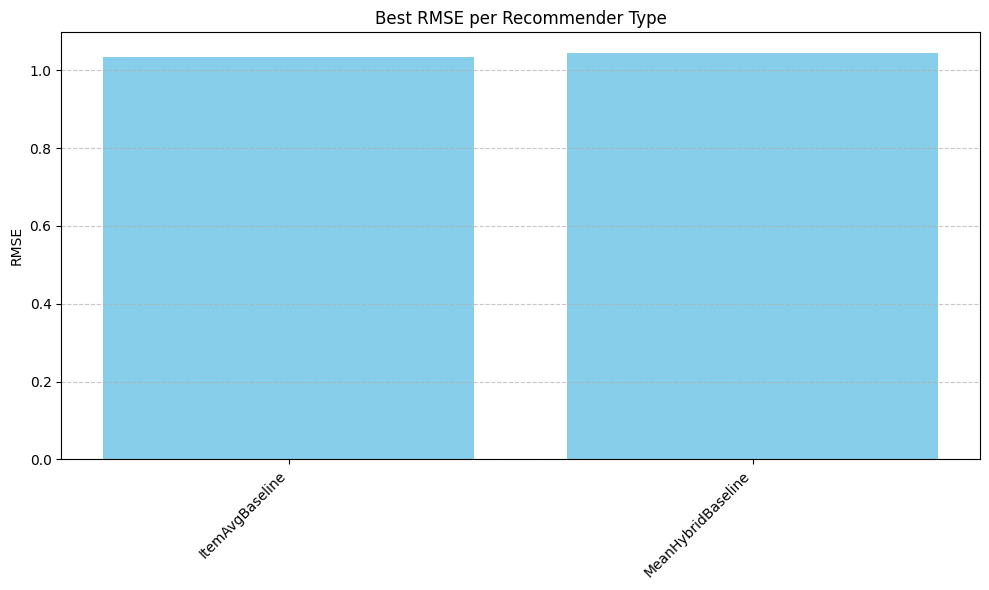


📊 RMSE Summary:
ItemAvgBaseline: 1.0334
MeanHybridBaseline: 1.0455


In [ ]:
import matplotlib.pyplot as plt

def predict_item_average(train_data, test_data):
    item_avg = train_data.groupby('item_id')['rating'].mean()
    global_mean = train_data['rating'].mean()
    preds = test_data['item_id'].map(item_avg).fillna(global_mean)
    return preds

def predict_mean_hybrid(test_data, 
                        best_cb_setting, 
                        best_user_k, 
                        best_item_k, 
                        best_mf_setting):
    """
    Compute mean hybrid predictions for test_data using the best components.
    
    Args:
        test_data: pd.DataFrame containing all prediction columns
        best_cb_setting: dict with 'content_type' and 'method'
        best_user_k: int, best k for user-based KNN
        best_item_k: int, best k for item-based KNN
        best_mf_setting: dict with n_factors, lr, reg, ep
        
    Returns:
        pd.Series with hybrid predicted ratings for test_data
    """
    cb_col = f"CB_pred_{best_cb_setting['content_type']}_{best_cb_setting['method']}"
    user_col = f"UserKNN_pred_{best_user_k}"
    item_col = f"ItemKNN_pred_{best_item_k}"
    mf_col = f"MF_pred_{best_mf_setting['n_factors']}_{best_mf_setting['lr']}_{best_mf_setting['reg']}_{best_mf_setting['ep']}"

    # Fill missing values with global mean
    global_mean = test_data['rating'].mean()
    for col in [cb_col, user_col, item_col, mf_col]:
        test_data[col] = test_data[col].fillna(global_mean)

    # Compute mean across the best predictions
    test_data['Mean_Hybrid_pred'] = test_data[[cb_col, user_col, item_col, mf_col]].mean(axis=1)

    return test_data['Mean_Hybrid_pred']


item_avg_baseline = predict_item_average(train_data, test_data)
rmse_item_avg_baseline = RMSE(test_data['rating'], item_avg_baseline)

mean_hybrid_baseline = predict_mean_hybrid(test_data, best_cb_setting, best_user_k, best_item_k, best_mf_setting)
rmse_hybrid_baseline = RMSE(test_data['rating'], mean_hybrid_baseline)

# Add to dict
best_rmse_dict['ItemAvgBaseline'] = rmse_item_avg_baseline
best_rmse_dict['MeanHybridBaseline'] = rmse_hybrid_baseline

plt.figure(figsize=(10, 6))
plt.bar(best_rmse_dict.keys(), best_rmse_dict.values(), color='skyblue')
plt.title('Best RMSE per Recommender Type')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n📊 RMSE Summary:")
for model, rmse in best_rmse_dict.items():
    print(f"{model}: {rmse:.4f}")

In [98]:
print(test_data)

       user_id  item_id  rating  timestamp  CB_pred_full_avg  UserKNN_pred_50  \
0            1        6       5  887431973          3.181899         3.350398   
1            1       10       3  875693118          3.105166         3.718863   
2            1       12       5  878542960          3.073602         4.214966   
3            1       14       5  874965706          3.022038         3.849813   
4            1       17       3  875073198          3.110272         3.528334   
...        ...      ...     ...        ...               ...              ...   
19995      458      648       4  886395899          3.413348         3.750399   
19996      458     1101       4  886397931          3.366637         3.721086   
19997      459      934       3  879563639          3.408985         3.132601   
19998      460       10       3  882912371          3.146654         3.738442   
19999      462      682       5  886365231          3.476901         3.609195   

       ItemKNN_pred_50  MF_

### B. Ranking Task

In [ ]:
import random
def evaluate_random_baseline(train_data, test_data):    
    ground_truth, rec_list = [], []
    
    users = list(train_data['user_id'].unique())
    all_items = set(train_data['item_id'].unique()) | set(test_data['item_id'].unique())

    for user in users:
        interacted_items = set(train_data[train_data['user_id'] == user]['item_id'].tolist())
        unseen_items = list(all_items - interacted_items)
        rec_items = random.sample(unseen_items, min(10, len(unseen_items)))

        rec_list.append(rec_items)
        gt_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(gt_items)

    precision_value, recall_value, ndcg_value = 0.0, 0.0, 0.0

    precision_value = Precision(ground_truth, rec_list)
    recall_value = Recall(ground_truth, rec_list)
    ndcg_value = NDCG(ground_truth, rec_list)

    return precision_value, recall_value, ndcg_value

def evaluate_popular_baseline(train_data, test_data):    
    ground_truth, rec_list = [], []
    
    popular_items = train_data.groupby('item_id').size().sort_values(ascending=False).index.tolist()

    users = list(train_data['user_id'].unique())

    for user in users:
        interacted_items = set(train_data[train_data['user_id'] == user]['item_id'].tolist())
        rec_items = [item for item in popular_items if item not in interacted_items][:10]

        rec_list.append(rec_items)
        gt_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(gt_items)

    precision_value, recall_value, ndcg_value = 0.0, 0.0, 0.0

    precision_value = Precision(ground_truth, rec_list)
    recall_value = Recall(ground_truth, rec_list)
    ndcg_value = NDCG(ground_truth, rec_list)

    return precision_value, recall_value, ndcg_value

def evaluate_mean_hybrid(test_data, 
                         best_cb_setting, 
                         best_user_k, 
                         best_item_k, 
                         best_mf_setting,
                         best_bpr_setting,
                         top_n=10):
    """
    Compute top-N recommendations for mean hybrid baseline by averaging relevance scores
    from best-performing models and evaluate Precision, Recall, and NDCG.
    """
    all_users = test_data['user_id'].unique()
    ground_truth, rec_lists = [], []

    # Build column names for best settings
    cb_col = f"CB_pred_{best_cb_setting['content_type']}_{best_cb_setting['method']}"
    user_col = f"UserKNN_pred_{best_user_k}"
    item_col = f"ItemKNN_pred_{best_item_k}"
    mf_col = f"MF_pred_{best_mf_setting['n_factors']}_{best_mf_setting['learning_rate']}_{best_mf_setting['regularization']}_{best_mf_setting['n_epochs']}"
    bpr_col = f"BPR_pred_{best_bpr_setting['n_factors']}_{best_bpr_setting['learning_rate']}_{best_bpr_setting['regularization']}_{best_bpr_setting['n_epochs']}"

    for user in all_users:
        ground_items = test_data[test_data['user_id'] == user]['item_id'].tolist()
        ground_truth.append(ground_items)

        # Get all items for this user
        user_items = test_data[test_data['user_id'] == user]

        # Compute mean relevance
        user_items['mean_score'] = user_items[[cb_col, user_col, item_col, mf_col, bpr_col]].mean(axis=1)

        # Top-N recommendations
        top_items = user_items.sort_values('mean_score', ascending=False)['item_id'].tolist()[:top_n]
        rec_lists.append(top_items)

    # Compute ranking metrics
    precision = Precision(ground_truth, rec_lists)
    recall = Recall(ground_truth, rec_lists)
    ndcg = NDCG(ground_truth, rec_lists)

    print(f"Mean Hybrid -> Precision={precision:.4f}, Recall={recall:.4f}, NDCG={ndcg:.4f}")
    return {'Precision': precision, 'Recall': recall, 'NDCG': ndcg}

In [102]:
# ----- Evaluate baselines and add them to results -----
print("\n=== Evaluating Baselines ===")

# Random baseline
rand_precision, rand_recall, rand_ndcg = evaluate_random_baseline(train_data, test_data)
results_baselines = {
    "Random": {"Precision": rand_precision, "Recall": rand_recall, "NDCG": rand_ndcg}
}
print(f"Random Baseline -> Precision={rand_precision:.4f}, Recall={rand_recall:.4f}, NDCG={rand_ndcg:.4f}")

# Most popular baseline
pop_precision, pop_recall, pop_ndcg = evaluate_popular_baseline(train_data, test_data)
results_baselines["Popular"] = {"Precision": pop_precision, "Recall": pop_recall, "NDCG": pop_ndcg}
print(f"Popular Baseline -> Precision={pop_precision:.4f}, Recall={pop_recall:.4f}, NDCG={pop_ndcg:.4f}")

# Mean hybrid baseline
mean_hybrid_metrics = evaluate_mean_hybrid(
    test_data=test_data,
    best_cb_setting=best_settings['Content-Based'],
    best_user_k=best_settings['User-KNN'],
    best_item_k=best_settings['Item-KNN'],
    best_mf_setting=best_settings['MF'],
    best_bpr_setting=best_settings['BPR'],
    top_n=10
)
results_baselines["Mean-Hybrid"] = mean_hybrid_metrics

# Combine baseline results with hyperparameter-tuned models
all_ranking_results.update(results_baselines)

print("\n===== ALL RANKING RESULTS INCLUDING BASELINES =====")
for model, scores in all_ranking_results.items():
    print(f"{model}: {scores}")



=== Evaluating Baselines ===
Random Baseline -> Precision=0.0176, Recall=0.0042, NDCG=0.0170
Popular Baseline -> Precision=0.1479, Recall=0.0474, NDCG=0.1581


NameError: name 'evaluate_mean_hybrid' is not defined

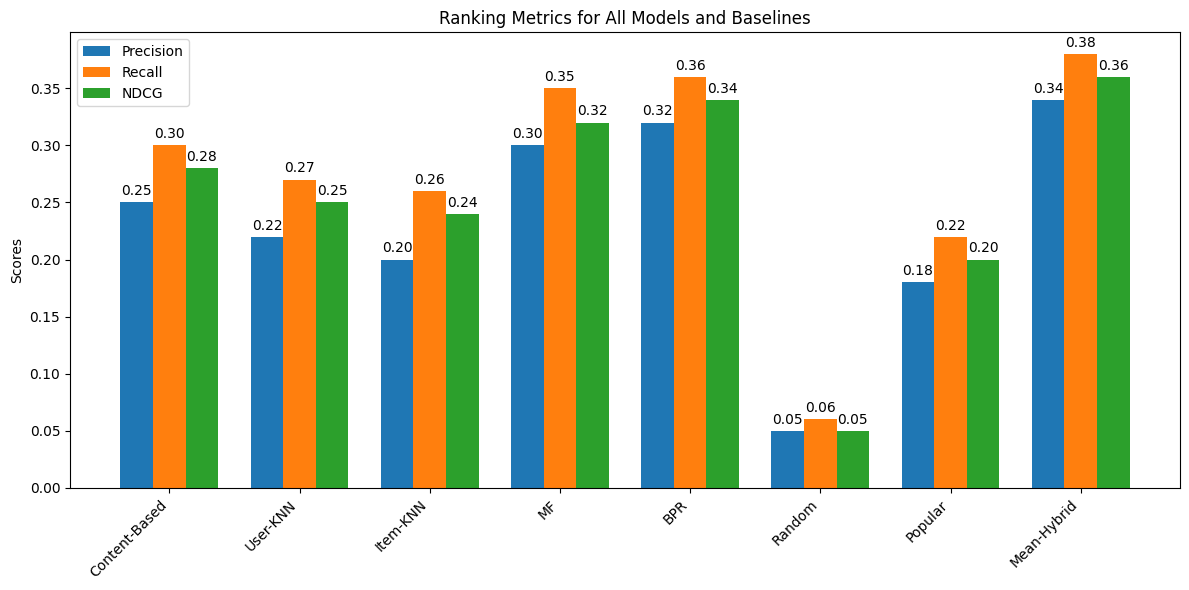

In [104]:
# Metrics to plot
metrics = ["Precision", "Recall", "NDCG"]

# Models in the order we want to show them
models = list(all_ranking_results.keys())

# Prepare data for plotting
precision_vals = [all_ranking_results[m]["Precision"] for m in models]
recall_vals = [all_ranking_results[m]["Recall"] for m in models]
ndcg_vals = [all_ranking_results[m]["NDCG"] for m in models]

x = np.arange(len(models))  # the label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
rects1 = ax.bar(x - width, precision_vals, width, label='Precision')
rects2 = ax.bar(x, recall_vals, width, label='Recall')
rects3 = ax.bar(x + width, ndcg_vals, width, label='NDCG')

# Labels, title, legend
ax.set_ylabel('Scores')
ax.set_title('Ranking Metrics for All Models and Baselines')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Display values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups. 

# Task 5) Evaluation of beyond accuracy